In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 42*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-17 17:26:06.361100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 17:26:06.580658: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 17:26:07.234727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Note to remember
# In this form of reshaping the datasets, u, u_xx, u_yy, u_t, v, v_xx and v_yy, v_t must be transposed to correctly show x and y coordinates

# This note book use only one snapshot (the last), does not estimate the time derivatives and use the exact u and v to reduce the loss residual. FInaly, the parameters are constant.

In [488]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-151,
               data_time_len=150,
               data_time_step=10)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

In [489]:
pattern.c.shape

(2, 100, 100, 15)

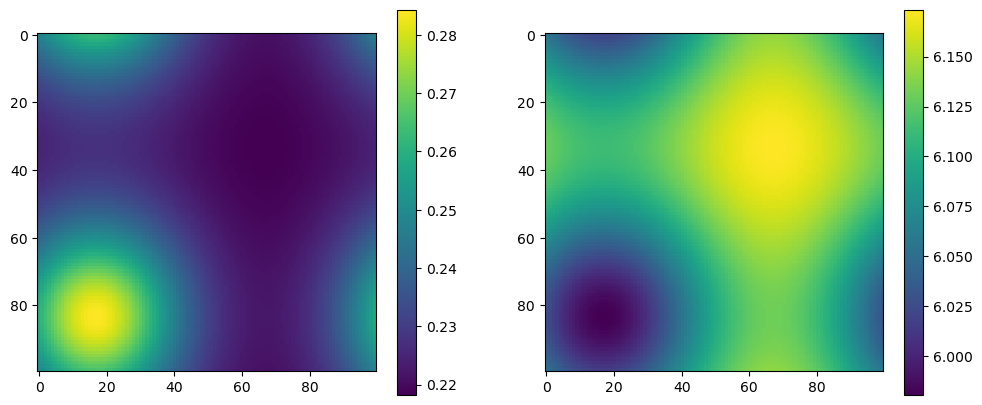

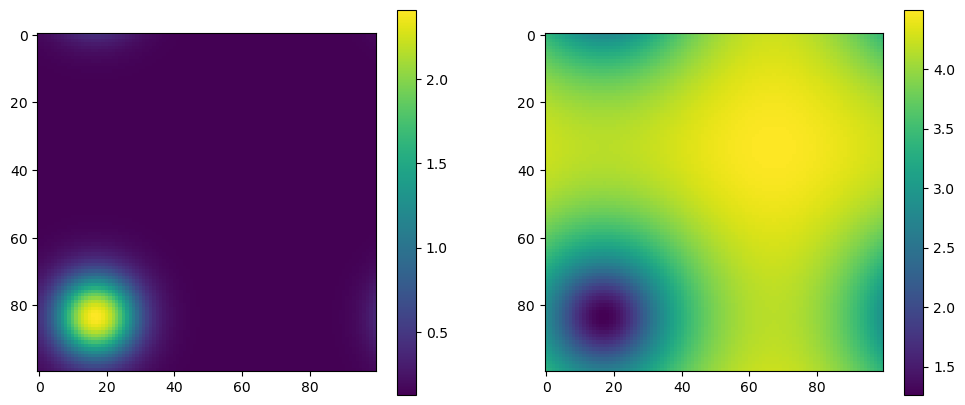

In [529]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.c[0,:, : , -14])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.c[1,:, : , -14])
plt.colorbar()

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.c[0,:, : , -5])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.c[1,:, : , -5])
plt.colorbar()

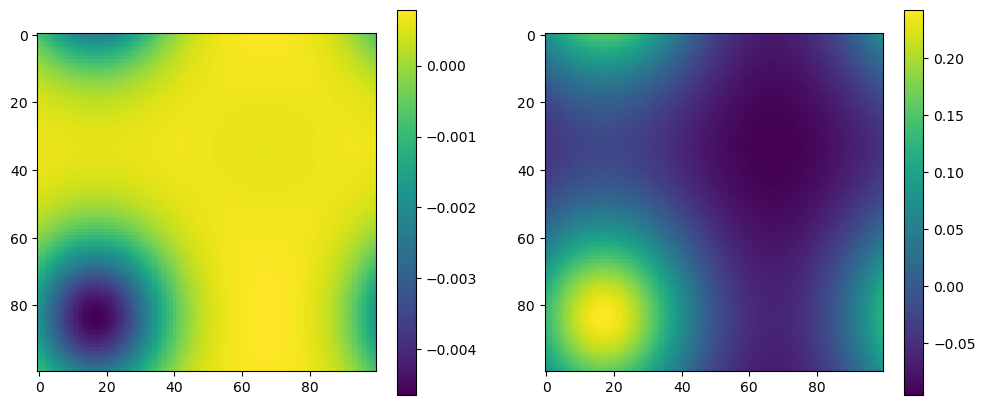

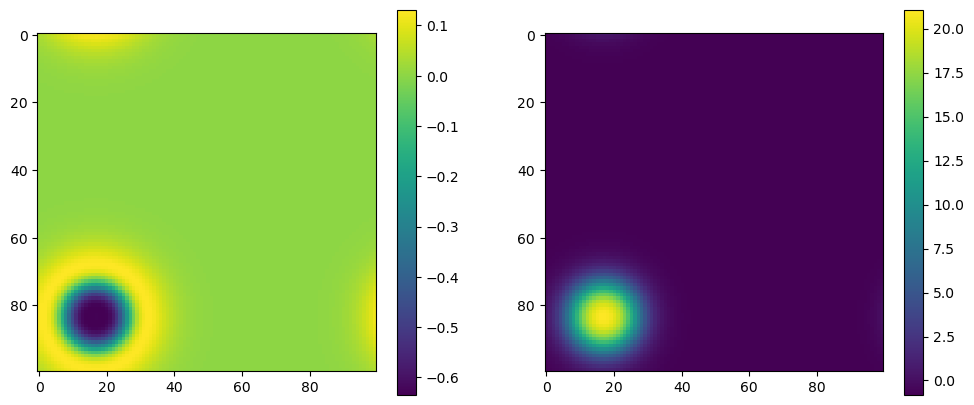

In [491]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , 0] + pattern.c_yy[0,:, : , 0]) - pattern.c_t[0,:, : , 0])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , 0] + pattern.c_yy[1,:, : , 0]) - pattern.c_t[1,:, : , 0])
plt.colorbar()

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [492]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)

def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )

In [493]:
# Inital Condition
# Select the first data point
ts_init = tf.constant(pattern.t_star[0:1], dtype=tf.float32)

T_init = ts_init[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H_init = H_cube(X, Y, T_init)

In [494]:
# Inner points
ts = tf.constant(pattern.t_star[::], dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H_inner = H_cube(X, Y, T)

In [530]:
ts

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([490., 500., 510., 520., 530., 540., 550., 560., 570., 580., 590.,
       600., 610., 620., 630.], dtype=float32)>

In [495]:
H_init.shape, H_inner.shape

(TensorShape([1, 100, 100, 3]), TensorShape([15, 100, 100, 3]))

In [496]:

#      Periodic boundary condition
X_L = tf.concat([np.repeat(x[0], y.shape[0])[:, np.newaxis],  
                 y[:, np.newaxis]],
                axis=1)
X_R = tf.concat([np.repeat(x[-1], y.shape[0])[:, np.newaxis],  
                 y[:, np.newaxis]],
                axis=1)
Y_T = tf.concat([x[:, np.newaxis],
                np.repeat(y[0], x.shape[0])[:, np.newaxis]],
                axis=1)
Y_B = tf.concat([x[:, np.newaxis],
                np.repeat(y[-1], x.shape[0])[:, np.newaxis]],
                axis=1)
def H_boundary(XY, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        XY[:, :],
                        np.repeat(T[i], XY.shape[0])[:, np.newaxis],
                    ],
                    axis=1,
                )
                for i in range(T.shape[0])
            ],
            axis=0,
        )

BC_LEFT = H_boundary(X_L, ts)
BC_RIGHT = H_boundary(X_R, ts)
BC_TOP = H_boundary(Y_T, ts)
BC_BOTTOM = H_boundary(Y_B, ts)


In [497]:
H_inner.shape

TensorShape([15, 100, 100, 3])

In [498]:
H_init.shape

TensorShape([1, 100, 100, 3])

In [499]:
# Data is a three column matrix as (x,y,t), where
# first x changes, then y, and finally t (like Boolean tables)
def H_flatten(H):
    return tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))

data_init = H_flatten(H_init)
data_inner = H_flatten(H_inner)


In [500]:
pattern.c.shape

(2, 100, 100, 15)

In [502]:
data_init.shape, data_inner.shape, BC_LEFT.shape

(TensorShape([10000, 3]), TensorShape([150000, 3]), TensorShape([1500, 3]))

In [503]:
def concentration_to_data(c):
    # Select the last time step
    # and reorder the x and y to match it
    # with H
    c_copy = np.einsum("cxy -> cyx", c.copy())
    #c_copy =  c.copy()
    #reshape c to flatten the data for each species
    c = c_copy.reshape((2, pattern.c.shape[1]*pattern.c.shape[2]))
    # and finnaly use its transposed, to have the each speacices in on column 
    c = c.T
    return c

c = concentration_to_data(pattern.c[:,:,:,-1])
c_xx = concentration_to_data(pattern.c_xx[:,:,:,-1])
c_yy = concentration_to_data(pattern.c_yy[:,:,:,-1])
c_t = concentration_to_data(pattern.c_t[:,:,:,-1])
    
def gen_series():    
    
    for i in range(data_inner.shape[0]):
        h_inner = data_inner[i,:]
        h_init = data_init[i%data_init.shape[0],:]
        
        left = BC_LEFT[i%BC_LEFT.shape[0], :]
        right = BC_RIGHT[i%BC_RIGHT.shape[0], :]
        top = BC_TOP[i%BC_TOP.shape[0], :]
        bottom = BC_BOTTOM[i%BC_BOTTOM.shape[0], :]
        
        c_1 = c[i%c.shape[0],:]
        #c_2 = c_xx[i%c_xx.shape[0],:]
        #c_3 = c_yy[i%c_yy.shape[0],:]
        #c_4 = c_t[i%c_t.shape[0],:]
        
        
        yield h_inner, h_init, left, right, top, bottom, c_1#, c_2, c_3, c_4  
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32,
                                                  tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((3,),(3,),(3,),(3,),
                                                   (3,),(3,),(2,)))

In [504]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))


In [505]:
theta_star = np.array([pattern.params["rho_u"], pattern.params["sigma_u"],
                       pattern.params["mu_u"], pattern.params["kappa_u"],
                       pattern.params["rho_v"], pattern.params["sigma_v"]])

In [506]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = tu.NN_Scaled([3, 256, 256, 256, 2], lb, ub, tf.float32)
#optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
optimizer=keras.optimizers.Adam(learning_rate=1e-4)
#optimizer=keras.optimizers.SGD(learning_rate=5e-4)   

def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

D_u_val, D_v_val = pattern.params["D_u"], pattern.params["D_v"]
(rho_u_val, sigma_u_val, mu_u_val,
 kappa_u_val, rho_v_val, sigma_v_val)= theta_star

print("="*20)
print("D_u: ", D_u_val)
print("D_v: ", D_v_val)
print("rho_u: ", rho_u_val)
print("rho_v: ", rho_v_val) 
print("sigma_u: ", sigma_u_val)
print("sigma_v: ", sigma_v_val) 
print("mu_u: ", mu_u_val) 
print("kappa_u: ", kappa_u_val)

def create_tf_var(name, value, no_clip=False):
    
    return tf.constant(value,
                       dtype=pinn.dtype,
                       name=name)

D_u = create_tf_var("D_u", D_u_val)    
D_v = create_tf_var("D_v", D_v_val)
rho_u = create_tf_var("rho_u", rho_u_val)    
rho_v = create_tf_var("rho_v", rho_v_val)
sigma_u = create_tf_var("sigma_u", sigma_u_val, no_clip=False)    
sigma_v = create_tf_var("sigma_v", sigma_v_val, no_clip=False)
mu_u = create_tf_var("mu_u", mu_u_val)    
kappa_u = create_tf_var("kappa_u", kappa_u_val)    
#     sigma_u2 = create_tf_var("sigma_u2", 0.0, no_clip=True)    
#     sigma_v2 = create_tf_var("sigma_v2", 0.0, no_clip=True)

w_sum = data_inner.shape[0] // data_init.shape[0]

@tf.function
def train_step_forward(elements):
    with tf.GradientTape(persistent=True) as tape: 
        
        H_inner = elements[0]
        H_init = elements[1]
        left = elements[2]
        right = elements[3]
        top = elements[4]
        bottom = elements[5]        
        uv_act = elements[6]
        
        #tape.watch(H_inner)
        tape.watch(elements[0:6])
        
        trainables = pinn.trainable_variables 

        with tf.GradientTape(persistent=True) as tape2:             
            #tape2.watch(H_inner)
            tape2.watch(elements[0:6])

            outputs = pinn.net(H_inner)
            
            
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])

            grad_u = tape2.gradient(u, H_inner)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, H_inner)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]

        grad_u_x = tape.gradient(u_x, H_inner)
        u_xx = grad_u_x[:, 0]
        grad_u_y = tape.gradient(u_y, H_inner)
        u_yy = grad_u_y[:, 1]
        grad_v_x = tape.gradient(v_x, H_inner)
        v_xx = grad_v_x[:, 0]
        grad_v_y = tape.gradient(v_y, H_inner)
        v_yy = grad_v_y[:, 1]
        
        u_rhs = D_u * (u_xx + u_yy) - u_t
        v_rhs = D_v * (v_xx + v_yy) - v_t
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = u_rhs + rho_u * f - mu_u * u + sigma_u
        f_v = v_rhs - rho_v * f + sigma_v
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #tape.watch(H_init)        
        outputs_init = pinn.net(H_init)  
        
        l2_u = tf.reduce_sum((uv_act[:, 0] - outputs_init[:,  0])**2)
        l2_v = tf.reduce_sum((uv_act[:, 1] - outputs_init[:,  1])**2)
        
        
        #tape.watch(left)
        #tape.watch(right)
        #tape.watch(top)
        #tape.watch(bottom)
        outputs_left = pinn.net(left)
        outputs_right = pinn.net(right)
        outputs_top = pinn.net(top)
        outputs_bottom = pinn.net(bottom)        
        
        l2_bc_LR = tf.reduce_sum((outputs_left - outputs_right)**2)
        l2_bc_TB = tf.reduce_sum((outputs_top - outputs_bottom)**2)
        
        
        l2 = l2_u + l2_v + l2_bc_LR + l2_bc_TB + l2_res_u + l2_res_v 

    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u, l2_v, l2_res_u, l2_res_v, l2_bc_LR, l2_bc_TB)

#@tf.function
def train_step_forward2(elements):
    with tf.GradientTape(persistent=True) as tape:         
        
        H_init = elements[0]
        uv_act = elements[1]
        
        tape.watch(H_init)
        #tape.watch(elements[0])
        
        trainables = pinn.trainable_variables 
        outputs_init = pinn.net(H_init)  
        
        l2_u = tf.reduce_sum((uv_act[:, 0] - outputs_init[:,  0])**2)
        l2_v = tf.reduce_sum((uv_act[:, 1] - outputs_init[:,  1])**2)
        
        l2 = l2_u + l2_v #+ l2_res_u + l2_res_v + l2_bc_LR + l2_bc_TB

    grads = tape.gradient(l2, trainables)
    #rint(grads)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u, l2_v)#, l2_res_u, l2_res_v, l2_bc_LR, l2_bc_TB)

D_u:  0.02
D_v:  1.0
rho_u:  0.4
rho_v:  3.0
sigma_u:  0.1
sigma_v:  1.0
mu_u:  1.0
kappa_u:  0.0


In [507]:
data_inner.shape, data_init.shape

(TensorShape([150000, 3]), TensorShape([10000, 3]))

In [433]:
w_sum

2

In [508]:
batch_size = data_inner.shape[0]//2#240000//16
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}, "
            f" total loss: {np.sum(losses)}"
            f"  L2 u: {losses[0]},  L2 v: {losses[1]}\n"
            f"  res u: {losses[2]}, res v: {losses[3]}\n"
            f"  BC LR: {losses[4]}, BC TB: {losses[5]}\n"
           )  
    
def print_callback2(printer, losses, epoch):
    printer(f"at epoch {epoch:d}, "
            f" total loss: {np.sum(losses)}"
            f"  L2 u: {losses[0]},  L2 v: {losses[1]}\n"
            
           )     

In [509]:
def epoch_callback(epoch, loss_samples, index):
    if epoch%400==0:
        (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data_init)
        plot_n_im([to(u), to(v)],
              figsize=(12, 3))

losses = tu.train(epochs=50000+1,
                  batch_size=batch_size,
                  dataset = ds,
                  train_step = train_step_forward,
                  train_step_returns_num = 6,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0,  total loss: 2558873.5652313232  L2 u: 30298.1015625,  L2 v: 2354425.125
  res u: 3155.4228515625, res v: 149993.734375
  BC LR: 20794.66015625, BC TB: 206.5212860107422

Time taken: 411.33s

Start of epoch 500
at epoch 500,  total loss: 66270.49649047852  L2 u: 14788.71337890625,  L2 v: 42488.73046875
  res u: 1523.8399963378906, res v: 1240.7099609375
  BC LR: 2754.336181640625, BC TB: 3474.16650390625

Time taken: 586.35s

Start of epoch 1000
at epoch 1000,  total loss: 37219.376861572266  L2 u: 11785.65185546875,  L2 v: 18446.6435546875
  res u: 584.9484558105469, res v: 3419.08642578125
  BC LR: 1460.2543334960938, BC TB: 1522.792236328125

Time taken: 586.15s

Start of epoch 1500
at epoch 1500,  total loss: 31834.527954101562  L2 u: 11235.2294921875,  L2 v: 13999.16455078125
  res u: 422.992431640625, res v: 3081.6529541015625
  BC LR: 1604.6396484375, BC TB: 1490.848876953125

Time taken: 584.80s

Start of epoch 2000
at epoch 2000,  total loss: 2609


Start of epoch 17000
at epoch 17000,  total loss: 632.7598066329956  L2 u: 148.8749542236328,  L2 v: 27.845650672912598
  res u: 104.4574203491211, res v: 223.5943145751953
  BC LR: 65.0525131225586, BC TB: 62.934953689575195

Time taken: 587.46s

Start of epoch 17500
at epoch 17500,  total loss: 627.0545740127563  L2 u: 137.85111236572266,  L2 v: 26.686137199401855
  res u: 104.97479057312012, res v: 233.13347625732422
  BC LR: 62.69301986694336, BC TB: 61.71603775024414

Time taken: 580.41s

Start of epoch 18000
at epoch 18000,  total loss: 584.6012735366821  L2 u: 127.24625396728516,  L2 v: 24.887394905090332
  res u: 99.14122772216797, res v: 215.09069442749023
  BC LR: 60.71721267700195, BC TB: 57.518489837646484

Time taken: 585.36s

Start of epoch 18500
at epoch 18500,  total loss: 717.739444732666  L2 u: 124.11420440673828,  L2 v: 26.754060745239258
  res u: 101.95498657226562, res v: 326.99591064453125
  BC LR: 65.0882511138916, BC TB: 72.83203125

Time taken: 580.73s

Start 


Start of epoch 33500
at epoch 33500,  total loss: 248.57177877426147  L2 u: 28.162564277648926,  L2 v: 13.453700542449951
  res u: 57.42459297180176, res v: 105.98398971557617
  BC LR: 22.641809463500977, BC TB: 20.90512180328369

Time taken: 575.63s

Start of epoch 34000
at epoch 34000,  total loss: 442.58527660369873  L2 u: 29.052932739257812,  L2 v: 14.359366416931152
  res u: 54.62183952331543, res v: 273.10877990722656
  BC LR: 34.149827003479004, BC TB: 37.29253101348877

Time taken: 572.51s

Start of epoch 34500
at epoch 34500,  total loss: 357.88784408569336  L2 u: 37.21134948730469,  L2 v: 26.589269638061523
  res u: 56.16865921020508, res v: 176.19400787353516
  BC LR: 26.43928337097168, BC TB: 35.285274505615234

Time taken: 580.78s

Start of epoch 35000
at epoch 35000,  total loss: 201.09431505203247  L2 u: 25.179719924926758,  L2 v: 13.812961101531982
  res u: 56.762977600097656, res v: 67.29372215270996
  BC LR: 19.912833213806152, BC TB: 18.13210105895996

Time taken: 5


Start of epoch 50000
at epoch 50000,  total loss: 134.67287063598633  L2 u: 15.208292961120605,  L2 v: 14.579643726348877
  res u: 41.77232599258423, res v: 40.04511070251465
  BC LR: 12.79330825805664, BC TB: 10.274188995361328

Time taken: 580.38s


In [510]:
pinn.save(".", "Koch_Meinhardt_5_Forward_pinn")

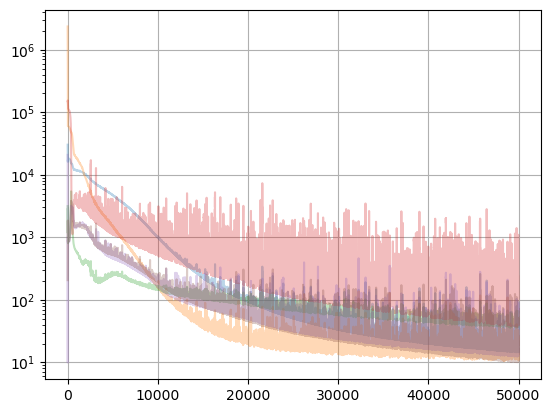

In [532]:
plt.plot(losses, alpha=.3)
plt.yscale('log');plt.grid()

In [537]:
optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>

In [ ]:
optimizer.lr.assign(2e-5)

In [515]:
def plot_state(pinn, data, i):
    (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)

    u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy)) - to(u_t)
    v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy)) - to(v_t)
    # X and Y are misoriented
    u_der = u_der.T
    v_der = v_der.T

    actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , i] + 
                                          pattern.c_yy[0,:, : , i]) - pattern.c_t[0,:, : , i]
    
    actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , i] + 
                                          pattern.c_yy[1,:, : , i]) - pattern.c_t[1,:, : , i]
    #u = pattern.c[0,:, : , i]
    #v = pattern.c[1,:, : , i]
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u =    rho_u * f - mu_u * u + sigma_u
    f_v =  - rho_v * f + sigma_v
    
    plot_n_im([to(u).T, pattern.c[0,:, : , i], to(v).T, pattern.c[1,:, : , i]], 
      ["u", "Actual u", "v", "Actual v"],          
      figsize=(12, 3)); plt.tight_layout()
    
    plot_n_im([to(u_xx).T, pattern.c_xx[0,:, : , i], to(u_yy).T, pattern.c_yy[0,:, : , i]], 
      ["u_xx", "Actual u_xx", "u_yy", "Actual u_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(v_xx).T, pattern.c_xx[1,:, : , i], to(v_yy).T, pattern.c_yy[1,:, : , i]],
              ["v_xx", "Actual v_xx", "v_yy", "Actual v_yy"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([to(u_t).T,  pattern.c_t[0,:, : , i],  to(v_t).T,  pattern.c_t[1,:, : , i]],
              ["u_t", "Actual u_t", "v_t", "Actual v_t"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([u_der,  actual_u_der],
               ["RHS U", "Actual RHS U"],          
               figsize=(12, 3)); plt.tight_layout()
    plot_n_im([v_der,  actual_v_der],
               ["RHS V", "Actual RHS V"],          
               figsize=(12, 3)); plt.tight_layout()
    plt.show()


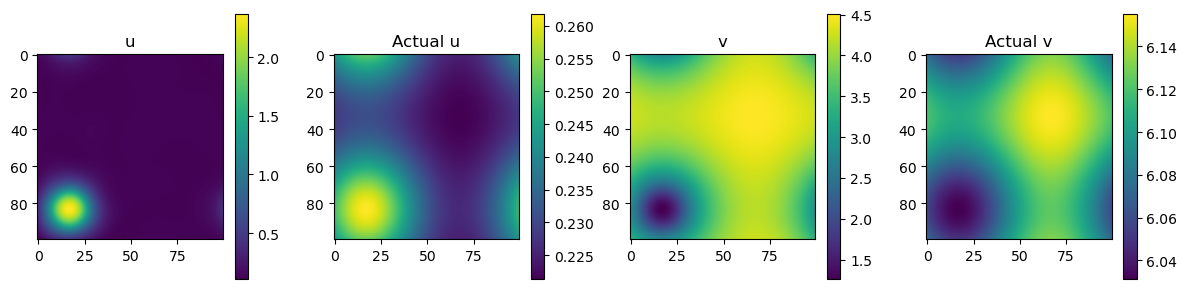

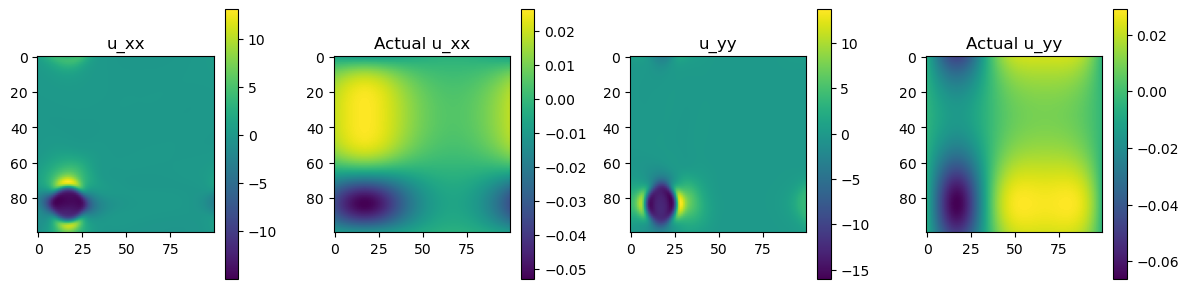

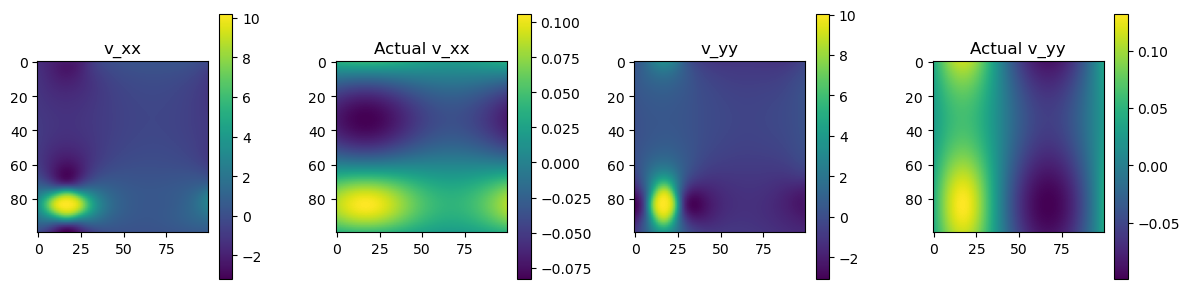

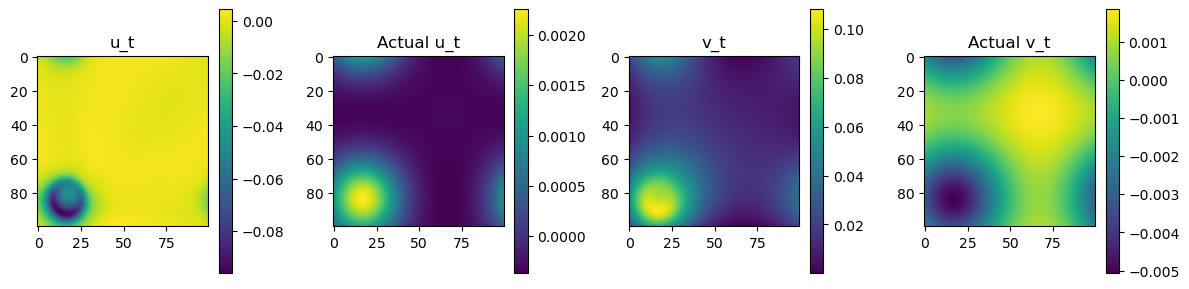

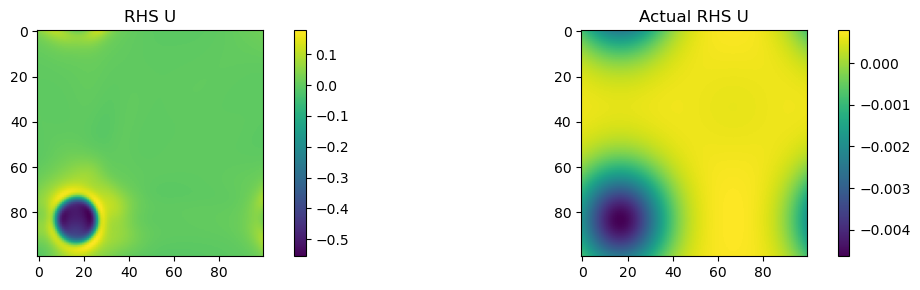

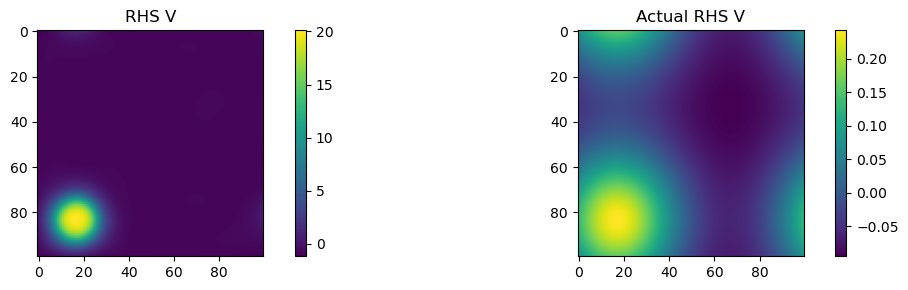

In [516]:
plot_state(pinn, data_init, 0)

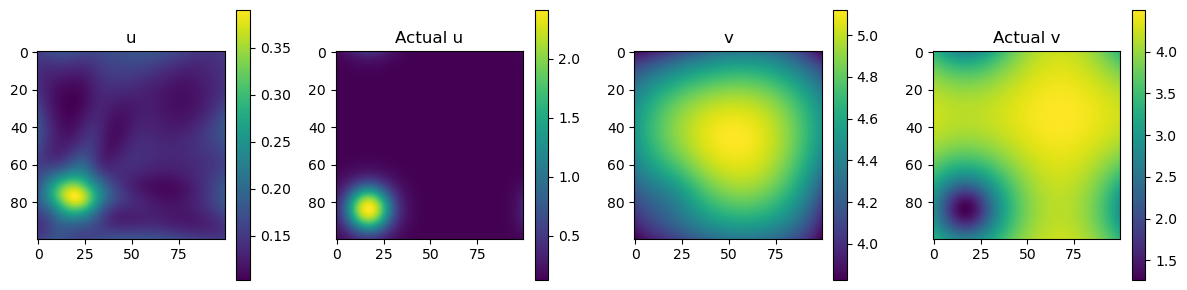

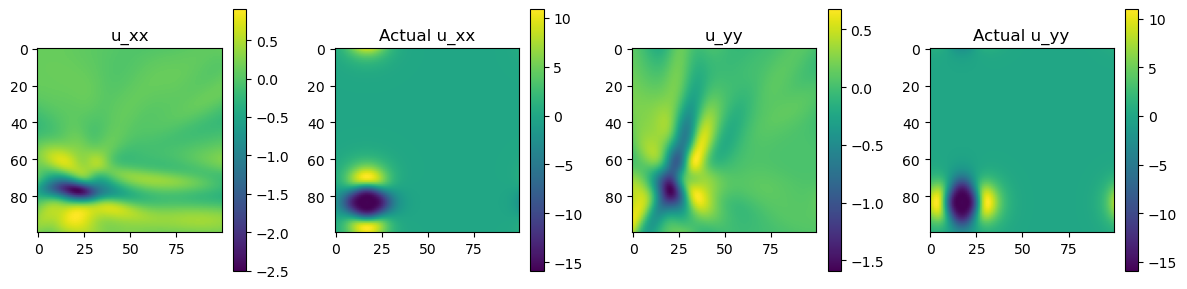

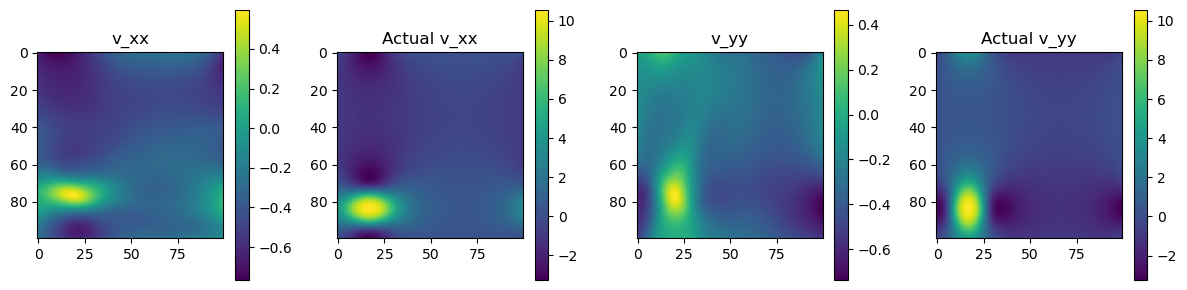

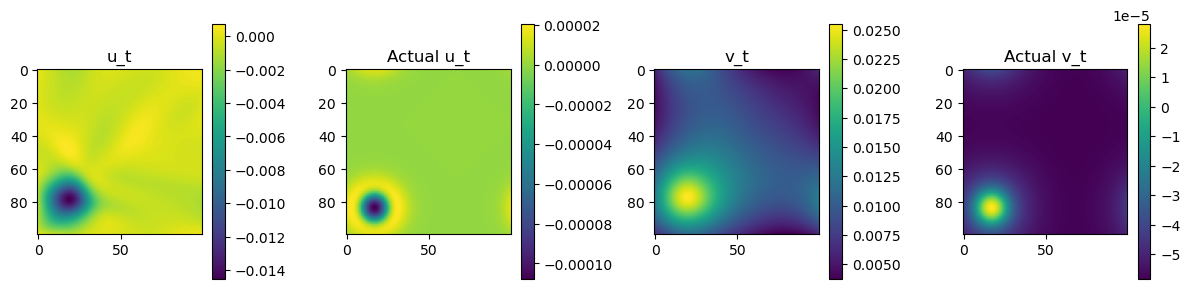

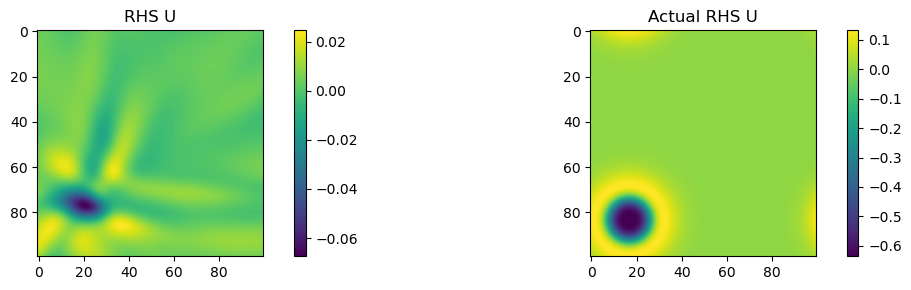

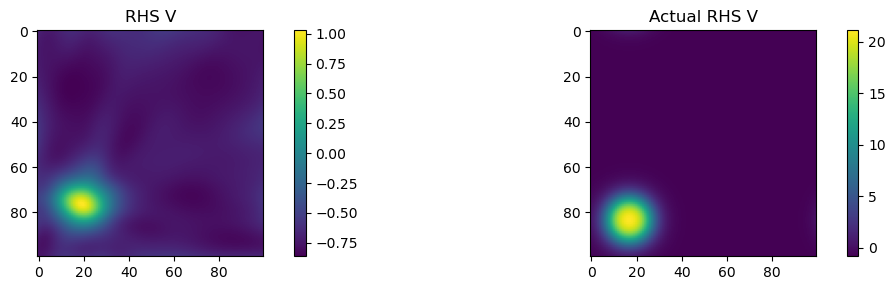

In [535]:
index = 6
plot_state(pinn, data_inner[(index-1)*10000:(index)*10000,:], index)